<a href="https://colab.research.google.com/github/nawaltahir/DevelopersHub_Corporation/blob/main/House_Price_Predic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3: House Price Prediction
## Objective:
Predict house prices using property features such as size, bedrooms, and location.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from scipy.stats import uniform
import lightgbm as lgb

In [2]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive/')

# Load dataset (replace with your dataset)
data = pd.read_csv('/content/drive/MyDrive/Housing.csv')

Mounted at /content/drive/


## Pre-Processing

In [3]:
data[["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]] = (
    data[["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]].replace({"yes": 1, "no": 0})
)
data[["furnishingstatus"]] = data[["furnishingstatus"]].replace({"furnished": 1, "semi-furnished": 0.5, "unfurnished": 0})
data.info()
data.to_csv('modified_house_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             545 non-null    int64  
 1   area              545 non-null    int64  
 2   bedrooms          545 non-null    int64  
 3   bathrooms         545 non-null    int64  
 4   stories           545 non-null    int64  
 5   mainroad          545 non-null    int64  
 6   guestroom         545 non-null    int64  
 7   basement          545 non-null    int64  
 8   hotwaterheating   545 non-null    int64  
 9   airconditioning   545 non-null    int64  
 10  parking           545 non-null    int64  
 11  prefarea          545 non-null    int64  
 12  furnishingstatus  545 non-null    float64
dtypes: float64(1), int64(12)
memory usage: 55.5 KB


/tmp/ipython-input-3-836878662.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[["mainroad","guestroom","basement","hotwaterheating","airconditioning","prefarea"]].replace({"yes": 1, "no": 0})
/tmp/ipython-input-3-836878662.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[["furnishingstatus"]] = data[["furnishingstatus"]].replace({"furnished": 1, "semi-furnished": 0.5, "unfurnished": 0})


In [4]:
encoder= LabelEncoder()
data['furnishingstatus'] = encoder.fit_transform(data['furnishingstatus'])
encoding_col=['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']
for col in encoding_col:
  data[col] = encoder.fit_transform(data[col])
data.head(10)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,232,3,1,2,1,0,0,0,1,2,1,2
1,12250000,260,3,3,3,1,0,0,0,1,3,0,2
2,12250000,268,2,1,1,1,0,1,0,0,2,1,1
3,12215000,237,3,1,1,1,0,1,0,1,3,1,2
4,11410000,232,3,0,1,1,1,1,0,1,2,0,2
5,10850000,237,2,2,0,1,0,1,0,1,2,1,1
6,10150000,256,3,2,3,1,0,0,0,1,2,1,1
7,10150000,283,4,2,1,1,0,0,0,0,0,0,0
8,9870000,249,3,0,1,1,1,1,0,1,2,1,2
9,9800000,172,2,1,3,1,1,0,0,1,1,1,0


## Feature Engineering

In [5]:
# Select features and target variable
X = data[['area','bedrooms','bathrooms','stories','mainroad','guestroom','basement','hotwaterheating','airconditioning','parking','prefarea','furnishingstatus']]  # Replace with actual feature columns
y = data['price']  # Target column (house price)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,232,3,1,2,1,0,0,0,1,2,1,2
1,12250000,260,3,3,3,1,0,0,0,1,3,0,2
2,12250000,268,2,1,1,1,0,1,0,0,2,1,1
3,12215000,237,3,1,1,1,0,1,0,1,3,1,2
4,11410000,232,3,0,1,1,1,1,0,1,2,0,2


In [6]:
# Check for duplicate entries
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 0


In [7]:

# Define features and target
X = data.drop(columns=['price'])
y = data['price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for CNN
X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)



##Model Selection, Training, Evalution and Fine Tuning

In [9]:
# LightGBM Model
lgb_model = lgb.LGBMRegressor(force_row_wise=True)  # Add force_row_wise=True
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)
print(f"LightGBM Model MAPE: {mape_lgb * 100:.2f}%")

# Define a smaller parameter distribution
param_dist = {
    'learning_rate': uniform(0.01, 0.05),
    'n_estimators': [500],
    'max_depth': [5, 7],
    'num_leaves': [20, 30],
    'min_child_samples': [20],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Perform randomized search with fewer iterations and folds
random_search = RandomizedSearchCV(estimator=lgb.LGBMRegressor(random_state=42),
                                    param_distributions=param_dist,
                                    n_iter=10,  # Reduce number of iterations
                                    scoring='neg_mean_absolute_percentage_error',
                                    cv=2,  # Reduce number of folds
                                    verbose=1,
                                    n_jobs=-1,
                                    random_state=42)

# Fit randomized search
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Train the best model with early stopping
best_model = lgb.LGBMRegressor(
    **best_params,
    random_state=42,
    force_row_wise=True
)

# Create validation set for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit with early stopping
best_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric='mape',
    #early_stopping_rounds=50,
    #verbose=False
)

# Predict and calculate MAPE
y_pred_lgb = best_model.predict(X_test)
mape_lgb = mean_absolute_percentage_error(y_test, y_pred_lgb)
print(f"Light GBM Model MAPE: {mape_lgb * 100:.2f}%")
# Calculate MSE and RMSE for LightGBM
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
rmse_lgb = np.sqrt(mse_lgb)
print(f"LightGBM Model MSE: {mse_lgb:.2f}")
print(f"LightGBM Model RMSE: {rmse_lgb:.2f}")

[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 436, number of used features: 12
[LightGBM] [Info] Start training from score 4706527.385321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [10]:
from sklearn.linear_model import LinearRegression

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
# Reshape X_train_scaled to 2D for Linear Regression
X_train_scaled_2D = X_train_scaled.reshape(X_train_scaled.shape[0], -1)
lr_model.fit(X_train_scaled_2D, y_train)

# Predict and evaluate
# Reshape X_test_scaled to 2D
X_test_scaled_2D = X_test_scaled.reshape(X_test_scaled.shape[0], -1)
y_pred_lr = lr_model.predict(X_test_scaled_2D)
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
print(f"Linear Regression Model MAPE: {mape_lr * 100:.2f}%")

# Calculate MSE and RMSE for Linear Regression
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)

print(f"Linear Regression Model MSE: {mse_lr:.2f}")
print(f"Linear Regression Model RMSE: {rmse_lr:.2f}")

Linear Regression Model MAPE: 21.43%
Linear Regression Model MSE: 1801019668309.62
Linear Regression Model RMSE: 1342020.74


| Metric                                    | LightGBM             | Linear Regression        | Better Model                           |
| ----------------------------------------- | -------------------- | ------------------------ | -------------------------------------- |
| **MAPE** (Mean Absolute Percentage Error) | **22.06%**           | **21.43%**               | **Linear Regression** (slightly lower) |
| **MSE** (Mean Squared Error)              | 1,965,170,442,256.57 | **1,801,019,668,309.62** | **Linear Regression**                  |
| **RMSE** (Root Mean Squared Error)        | 1,401,845.37         | **1,342,020.74**         | **Linear Regression**                  |


# Model Visulization

**Parity Plot**

Linear Regression not only had better numerical performance metrics (lower MSE, RMSE, MAPE), but this plot visually confirms its more consistent predictive performance.

LightGBM, though powerful, appears to underfit high-price houses in this case—likely due to suboptimal hyperparameters or insufficient training data for those price ranges.



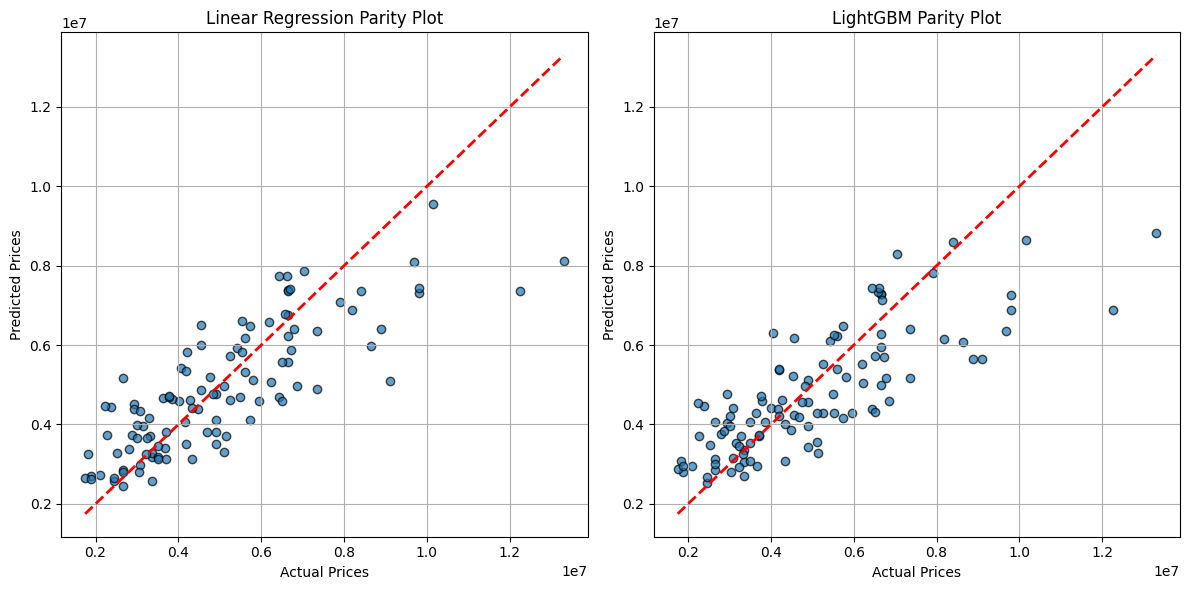

In [11]:
import matplotlib.pyplot as plt
# Create parity plot for Linear Regression
plt.figure(figsize=(12, 6))

# Subplot 1: Linear Regression Parity Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression Parity Plot')
plt.grid(True)

# Subplot 2: LightGBM Parity Plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_lgb, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('LightGBM Parity Plot')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


**Density Plot**

The plots of both models show slight positive skewnees with unimodal which means that the data is mostly evenly distributed around the central value, and have similar frequencies of observations on both sides.

In [13]:
# Calculate residuals for Linear Regression and LightGBM
residuals_lr = y_test - y_pred_lr  # Residuals for Linear Regression
residuals_lgb = y_test - y_pred_lgb  # Residuals for LightGBM


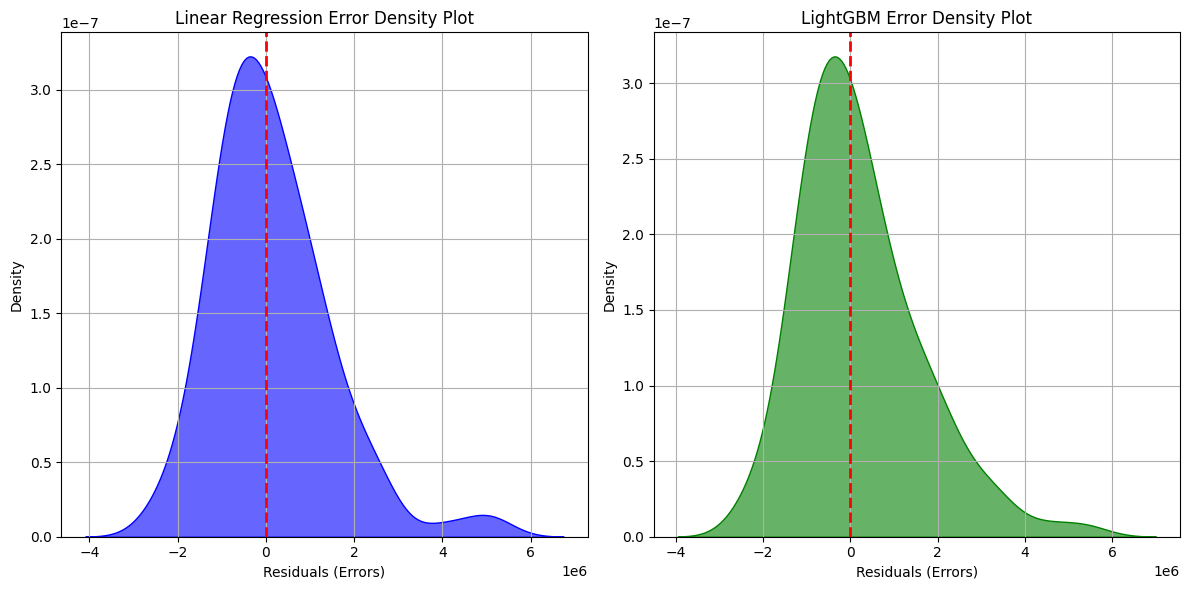

In [14]:
import seaborn as sns

# Create density plot for Linear Regression and LightGBM
plt.figure(figsize=(12, 6))

# Subplot 1: Linear Regression Error Density Plot
plt.subplot(1, 2, 1)
sns.kdeplot(residuals_lr, fill=True, color='blue', alpha=0.6)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.title('Linear Regression Error Density Plot')
plt.xlabel('Residuals (Errors)')
plt.grid(True)

# Subplot 2: LightGBM Error Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(residuals_lgb, fill=True, color='green', alpha=0.6)
plt.axvline(x=0, color='red', linestyle='--', lw=2)
plt.title('LightGBM Error Density Plot')
plt.xlabel('Residuals (Errors)')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


**Box Plot**

Light GBM model have less outliners than the Linear Regression model however, the interquartile range of the Linear Regression model is less than the Light GBM model.

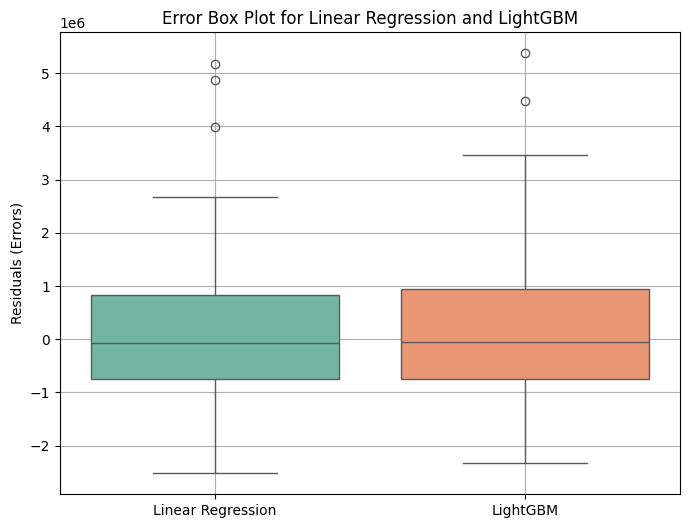

In [ ]:
# Create box plot for Linear Regression and LightGBM errors
plt.figure(figsize=(8, 6))

# Combine the residuals into a DataFrame for easier plotting
import pandas as pd
df_errors = pd.DataFrame({
    'Linear Regression': residuals_lr,
    'LightGBM': residuals_lgb
})

# Box plot
sns.boxplot(data=df_errors, palette="Set2")
plt.title('Error Box Plot for Linear Regression and LightGBM')
plt.ylabel('Residuals (Errors)')
plt.grid(True)

# Show the box plot
plt.show()


# **Conslusion**
In colclusion the Linear Regression model gives better performance than the Light GBM model.